In [1]:
import cv2
import os
from math import ceil
import time
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import random
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import matplotlib as mpl

# mpl.rcParams['animation.ffmpeg_path_vid_vid_vid_vid'] = r'C:\\ffmpeg\\bin\\ffmpeg.exe'
import matplotlib.gridspec as gridspec

from koniq_api.lib import MyModel

import os
import sys
import pandas as pd

2022-05-08 17:57:29.567127: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexkkir/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2022-05-08 17:57:29.567273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Loaded Kuti


In [2]:
MODEL = MyModel()

Loading model InceptionResNetV2


2022-05-08 17:57:32.511882: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-08 17:57:32.512005: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alexkkir-Extensa-215-51G): /proc/driver/nvidia/version does not exist
2022-05-08 17:57:32.513449: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class VideoReader:
    def __init__(self, path):
        self.path = path
        if not os.path.exists(path):
            print(f'Path {path} doesnt exists')
        else:
            print('Path exists')
        self.cap = cv2.VideoCapture(path)
        self.height = int(self.cap.get(4))
        self.width = int(self.cap.get(3))
        self.it = iter(self)
        self.length = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

    def __iter__(self):
        while self.cap.isOpened():
            ret, frame = self.cap.read()
            if ret == False:
                break
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            yield frame

    def __call__(self):
        return next(self.it)

    def __del__(self):
        self.cap.release()

    def refresh(self):
        self.cap = cv2.VideoCapture(self.path)

In [4]:
MAX = 2

class MetricArray:
    def __init__(self, vid_path, mask_path, n_height, n_width):
        self.vid = None if vid_path is None else VideoReader(vid_path)
        self.mask_raw = None if mask_path is None else VideoReader(mask_path)
        
        self.n_height = n_height
        self.n_width = n_width
        self.block_height = self.vid.height // n_height
        self.block_width = self.vid.width // n_width
        
        self.scores = np.zeros((self.vid.length, self.n_height, self.n_width))
        self.metric = MODEL
        self.mask = np.zeros_like(self.scores)
        self.length = self.vid.length

    def get_subframe(self, frame, i, j) -> np.array:
        return frame[
               i * self.block_height: min(self.vid.height, (i + 1) * self.block_height),
               j * self.block_width: min(self.vid.width, (j + 1) * self.block_width)
               ]

    def split_video(self):
        """
        devide video on n * m subvideos and save each of them in ./tmp/ folder
        :return:
        """

        TMP_DIR = './tmp/'
        if not os.path.exists(TMP_DIR): 
            os.mkdir(TMP_DIR)
        for f in os.listdir(TMP_DIR):
            os.remove(TMP_DIR + f)

        fourcc = cv2.VideoWriter_fourcc(*'XVID')

        for i in range(self.n_height):
            for j in range(self.n_width):
                out = cv2.VideoWriter(f'{TMP_DIR}{i}_{j}.mp4', fourcc, vid.fps, (self.block_width, self.block_height))
                for frame in vid:
                    subframe = self.get_subframe(frame, i, j)
                    out.write(subframe)
                out.release()
                vid.refresh()
                
    
    def calc_raw_metric(self):
        for frame_idx, frame in tqdm(enumerate(self.vid), total=self.length):
            for i in range(self.n_height):
                for j in range(self.n_width):
                    subframe = self.get_subframe(frame, i, j)
                    score = self.metric(subframe)
                    self.scores[frame_idx][i][j] = score
    
    def resize_mask(self):
        self.mask_raw.refresh()
        for fi, frame in enumerate(self.mask_raw):
            frame = cv2.resize(frame, (self.vid.width, self.vid.height)).astype('uint8')
            for i in range(self.mask.shape[1]):
                for j in range(self.mask.shape[2]):
                    self.mask[fi][i][j] = frame[ 
                        i * self.block_height : (i + 1) * (self.block_height ), 
                        j * self.block_width: (j + 1) * (self.block_width)].mean() / 255     
        self.mask_raw.refresh()


    def apply_mask(self):
        return self.scores * self.mask
    
    def calc_metric(self):
        return self.apply_mask().mean()

In [5]:
def calc_pcc(x, y):
    return np.corrcoef(x, y)[0][1]

In [6]:
def parse(name: str) -> dict[str]:
    out = dict()
    name = name.split('.')[0]
    name = name.split('enc_res_')[1]

    str1 = '_mv_offline_2k_v1_'
    str2 = '_mv_offline_2k_'

    if name.find(str1) >= 0:
        method = 'mv_offline_2k_v1'
        name = name.split(str1)
    else:
        method = 'mv_offline_2k'
        name = name.split(str2)

    out['method'] = method
    out['codec'] = name[0]

    name = name[1]
    name = name.split('_')
    out['crf'] = int(name[-1])

    name = '_'.join(name[0:-1])
    out['name'] = name
    return out

def get_1_score(df: pd.DataFrame, name, codec, crf, method):
    x = df[(df['comparison'] == 'ugc') & (df['sequence'] == name) & (df['crf'] == int(crf)) & (df['codec'] == codec) & (
            df['preset'] == method)]
    x = x['subjective']

    if len(x) == 1:
        x = float(x)
    else:
        return None
    
    return x

def get_subj_scores(videos, file='subjective_scores.csv'):
    subj = pd.read_csv(file, sep=';')
    return [get_1_score(subj, **parse(name)) for name in videos]

In [7]:
def test_metric_single(ma: MetricArray, subjs: list, metric, param, give_scores):
    scores = []
    for video, bscore in zip(videos, bscores):
        ma.scores = bscore
        if param is None:
            score = metric(ma)
        else:
            score = metric(ma, **param)
        scores.append(score)
    if give_scores:
        return calc_pcc(scores, subjs), scores
    else:
        return calc_pcc(scores, subjs)


def test_metric(ma: MetricArray, subjs: list, metric, params=None) -> tuple:
    if params is None:
        return test_metric_single(m, subjs, metric, {}, True)
    else:
        best_score = test_metric_single(m, subjs, metric, params[0], False)
        best_param = params[0]
        for param in params:
            score = test_metric_single(m, subjs, metric, param, False)
            if score > best_score:
                best_score = score
                best_param = param
        print('%40s%s' % ('', best_param))
        return test_metric_single(m, subjs, metric, best_param, True)

In [12]:
seq_name = 'happy_dog'
file = f'np_arrays/{seq_name}_div8.npy'
folder = f'ugc/{seq_name}_x265/'
mask_path = f'masks/{seq_name}_mask.mp4'
videos = sorted(os.listdir(folder))

bscores = []
subjs = get_subj_scores(videos)

with open(file, 'rb') as f:
    try:
        while True:
            bscores.append(np.load(f))
    except:
        pass

print(f'Found {len(bscores)} files')
print(f'Found {len(subjs)} subj scores')

videos = videos[0:len(bscores)]
subjs = subjs[0:len(bscores)]
assert len(videos) == len(bscores) == len(subjs)

print('Length after cropping:', len(bscores))

deleted = 0
for i in range(len(subjs)):
    if subjs[i - deleted] is None:
        subjs.pop(i - deleted)
        videos.pop(i - deleted)
        bscores.pop(i - deleted)
        deleted += 1

print('Length after excluding absent:', len(bscores))

m = MetricArray(folder + videos[0], mask_path, 8, 8)
m.resize_mask()

Found 1 files
Found 23 subj scores
Length after cropping: 1
Length after excluding absent: 1
Path exists
Path masks/happy_dog_mask.mp4 doesnt exists


In [9]:
def calc_metric_multip(m: MetricArray) -> float:
    new_mask = m.mask.copy()
    res = 0
    for mask, metric in zip(new_mask, m.scores):
        res += (mask * metric).mean()
    res /= m.length
    return res

def calc_metric_weighted(m: MetricArray) -> float:
    new_mask = m.mask.copy()
    res = 0
    for mask, metric in zip(new_mask, m.scores):
        res += (mask * metric).sum() / mask.sum()
    res /= m.length
    return res

def calc_metric_norm(m: MetricArray) -> float:
    new_mask = m.mask.copy()
    for i in range(m.length):
        frame = new_mask[i]
        frame -= frame.mean()
        frame /= frame.std()
        frame += 1
        new_mask[i] = frame
        # print(frame.mean(), frame.mean(), frame.std())
    res = 0
    for mask, metric in zip(new_mask, m.scores):
        res += (mask * metric).sum() / mask.sum()
    res /= m.length
    return res

def calc_metric_bg_25(m: MetricArray) -> float:
    return calc_metric_bg(m, 0.75, 0.25)

def calc_metric_bg_minus_93_2(m: MetricArray) -> float:
    return calc_metric_bg(m, 0.93, -0.02)

def calc_metric_bg_minus_95_5(m: MetricArray) -> float:
    return calc_metric_bg(m, 0.95, -0.05)

def calc_metric_bg(m: MetricArray, contrast, bias) -> float:
    new_mask = m.mask.copy()
    new_mask = new_mask * contrast + bias
    res = 0
    for mask, metric in zip(new_mask, m.scores):
        res += (mask * metric).sum() / mask.sum()
    res /= m.length
    return res

def calc_metric_sum(m):
    return m.scores.mean()

# def calc_metrive_bg_adaptive_bf(m: MetricArray) -> float:    
#     best_score, best_contrast, best_bias = 0, 0, 0
#     for contrast in contrast_vals:
#         for bias in bias_vals:
#             score = calc_metric_bg_25(m, contrast, bias)
#             if best_score < score:
#                 best_score = score
#                 best_contrast = contrast
#                 best_bias = bias
#     print(">", best_contrast, best_bias)
#     return best_score

In [10]:
print(m.mask.sum())

0.0


                                             calc_metric_sum: nan                                     
                                          calc_metric_multip: nan                                     
                                        calc_metric_weighted: nan                                     
                                           calc_metric_bg_25: nan                                     
                                            calc_metric_norm: nan                                     
None 0


/home/alexkkir/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:178: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/home/alexkkir/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/alexkkir/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2487: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/alexkkir/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/alexkkir/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/tmp/ipykernel_3181177/3079760512.py:13: RuntimeWarning: invalid value encountered in double_scalars
  res += (mask * metric).sum()

TypeError: Value after * must be an iterable, not NoneType

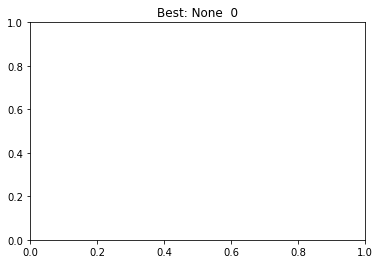

In [11]:
my_metrics = [
    (calc_metric_sum,),
    (calc_metric_multip,),
    (calc_metric_weighted,),
    (calc_metric_bg_25,),
    # (calc_metric_bg_minus_93_2,),
    # (calc_metric_bg_minus_95_5,),
    (calc_metric_norm,),
    # (calc_metric_bg, [{'contrast': 0.93, 'bias': -0.02}]),
    # (calc_metric_bg, [{'contrast': q[0], 'bias': q[1]} for q in zip(np.linspace(0.9, 1, 100), np.linspace(-0.1, 0.1, 100))])
]

best_m = None
best_sc = 0
best_pair = None
for pair in my_metrics:
    metric = pair[0]
    param = None if len(pair) < 2 else pair[1]
    score, scores = test_metric(m, subjs, metric, param)
    if score > best_sc:
        best_sc = score
        best_m = metric.__name__
        best_pair = pair
    print(f'%60s: %-40s' % (pair[0].__name__, score))

print(best_m, best_sc)
plt.title(f'Best: {best_m}  {round(best_sc, 4)}')
plt.scatter(subjs, test_metric(m, subjs, *best_pair)[1])
plt.show()

In [ ]:
my_metrics = [
    (calc_metric_bg, [{'contrast': q[0], 'bias': q[1]} for q in zip(np.linspace(0.9, 1, 100), np.linspace(-0.1, 0.1, 100))])
]

best_m = None
best_sc = 0
best_pair = None
for pair in my_metrics:
    metric = pair[0]
    param = None if len(pair) < 2 else pair[1]
    score, scores = test_metric(m, subjs, metric, param)
    if score > best_sc:
        best_sc = score
        best_m = metric.__name__
        best_pair = pair
    print(f'%60s: %-40s' % (pair[0].__name__, score))

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import product as dot


fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')

def f(x, y):
    return calc_metric_bg(m, x, y)

x = list(np.linspace(0.5, 1.5, 20))
y = list(np.linspace(-1, 1, 20))

coords = np.array(list(dot(x, y)))
z = [f(*c) for c in coords]
z = [z if 0 <= z <= 1 else 0 for z in z]
coords = coords.T

ax = plt.axes(projection='3d')
ax.plot_trisurf(coords[0], coords[1], z,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');

In [ ]:

for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)